### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
import scipy
from scipy import optimize
import scipy.stats as stats
import emcee
import corner

In [3]:
data = np.load("transient.npy", "r")
t = data[:,0]
y = data[:,1]
yerr = data[:,2]

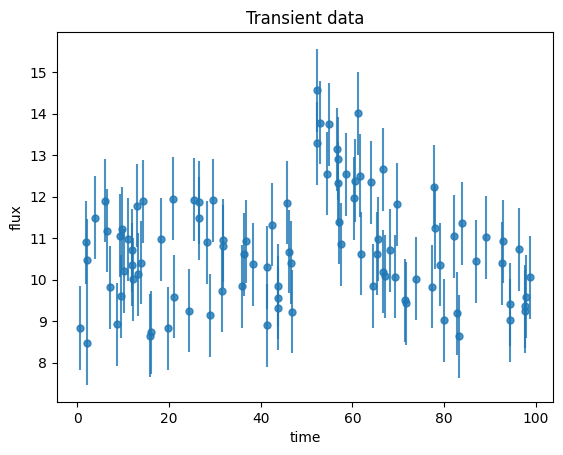

In [4]:
plt.errorbar(t, y, yerr=yerr, fmt='o', ms=5, alpha=0.8)
plt.xlabel("time")
plt.ylabel("flux")
plt.title("Transient data")
plt.show()


$$P(y_i | \text{model}(x_i, \text{par}), \sigma_{y_i}) = \frac{1}{\sigma_{y_i}\sqrt{2\pi}} \exp\left(-\frac{(y_i - \text{model}(x_i, \text{par}))^2}{2\sigma_{y_i}^2}\right)$$$$P(y_i | \text{model}(x_i, \text{par}), \sigma_{y_i}) = \frac{1}{\sigma_{y_i}\sqrt{2\pi}} \exp\left(-\frac{(y_i - \text{model}(x_i, \text{par}))^2}{2\sigma_{y_i}^2}\right)$$

In [5]:

'''
# Model: sharp burst with exponential tail
def model (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])              
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))
    
    return modello


#log likelihood ()
def logL(par, data, model=model_):
    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# parameters which minimize -logL
def best_par(model=model_, data=data):
    par_0 = [48, 10, 4, 1/20]
    
    neg_logL = lambda par : -logL(par, data, model)
    return scipy.optimize.fmin_bfgs(neg_logL, par_0, disp=False)


def Prior(par_mcmc):
    prior_0 = stats.uniform(0,100).pdf(par_mcmc[0])
    prior_1 = stats.uniform(0,50).pdf(par_mcmc[1])
    prior_2 = stats.uniform(0,50).pdf(par_mcmc[2])
    prior_3 = stats.uniform(-5,5).pdf(np.log(par_mcmc[3]))
    
                                      
    return prior_0 * prior_1 * prior_2* prior_3

SyntaxError: incomplete input (3211209332.py, line 1)

In [6]:
#par = [t0,b,A,alpha]

def model_ (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))

    return modello

def Likelihood(par, data, model = model_):
    # Gaussian likelihood
    x = data[:, 0]
    y = data[:, 1]
    sigma_y = data[:,2]
    return np.prod((1/sigma_y**2 * np.sqrt(2*np.pi))*np.exp(-(y-model(x, par))**2 /2 /sigma_y**2)) #Fixed the typo 'sqret'




par0_mcmc = [[],[],[],[]]
def Prior(par_mcmc):
    prior_0 = stats.uniform(0,100).pdf(par_mcmc[0])
    prior_1 = stats.uniform(0,50).pdf(par_mcmc[1])
    prior_2 = stats.uniform(0,50).pdf(par_mcmc[2])
    prior_3 = stats.uniform(-5,5).pdf(np.log(par_mcmc[3]))


    return prior_0 * prior_1 * prior_2* prior_3


def logPosterior (par_mcmc, data, model = model_):
    logPrior = np.log(Prior(par_mcmc))
    if not np.isfinite(logPrior):
        return -np.inf
    # Calculate log-likelihood using the Likelihood function
    logLikelihood = np.log(Likelihood(par_mcmc, data, model)) #Changed np.logL to np.log(Likelihood(...))
    return logLikelihood + logPrior #Changed np.logL to logLikelihood

[47.87172507 10.28787755  6.34817498  0.11890542]


Text(0, 0.5, 'flux')

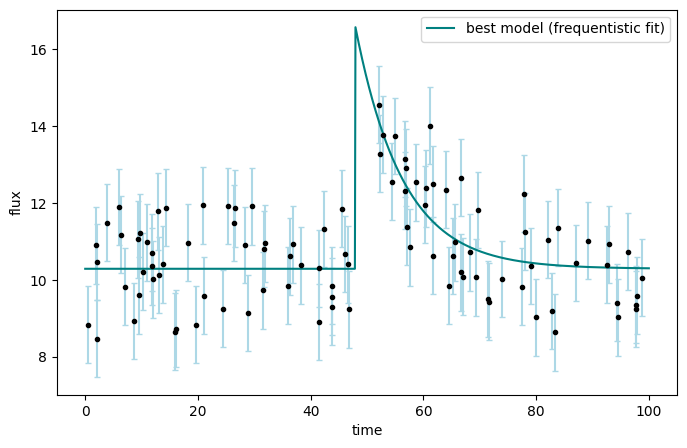

In [62]:
'''

Ndata = x.size

par = best_par(model_, data=data)
print(par)

xgrid = np.linspace(0, 100, 1000)
yfit = model_(xgrid, par)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1)
ax.plot(xgrid, yfit, label='best model (frequentistic fit)', color='teal')
ax.legend(loc='best', fontsize=10)
ax.set_xlabel('time')
ax.set_ylabel('flux')

[[], [], [], []]


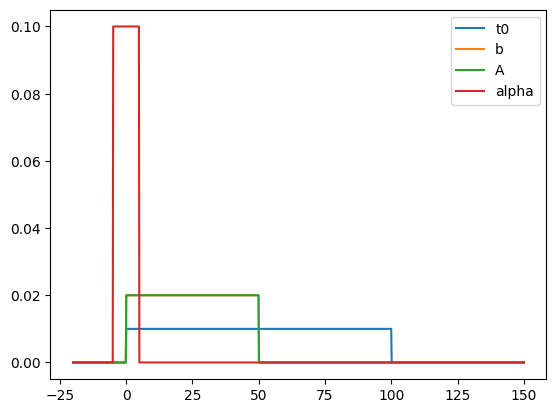

In [65]:
'''
# par = [t0, b, A , alpha]


x_linspace = np.linspace(-20,150, 1000)
par0_mcmc = [[],[],[],[]]
print(par0_mcmc)
def Prior_plot(x):
    for xi in x:
        
        par0_mcmc[0].append(stats.uniform.pdf(xi, loc=0, scale=100))
        par0_mcmc[1].append(stats.uniform.pdf(xi, loc=0, scale=50))
        par0_mcmc[2].append(stats.uniform.pdf(xi, loc=0, scale=50))
        ln_alpha = stats.uniform.pdf(xi, loc=-5, scale=10)
        par0_mcmc[3].append((np.exp(ln_alpha)))
    return par0_mcmc

par0_mcmc = Prior_plot(x_linspace)
    
#plot
plt.plot(x_linspace, par0_mcmc[0], label = 't0' )
plt.plot(x_linspace, par0_mcmc[1], label = 'b' )
plt.plot(x_linspace, par0_mcmc[2], label = 'A' )
plt.plot(x_linspace, np.log(par0_mcmc[3]), label = 'alpha')
plt.legend()
plt.show()
'''
   

In [20]:
par = [48, 10, 4, 1/20] #initial guesses

ndim = 4  # number of parameters in the model
nwalkers = 10 
nsteps = 5000 
print( "data dimensions: ", np.shape(data))

np.random.seed(0) 
starting_guesses = np.array(par)+ 1e-4* np.random.random((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=(data, ))

sampler.run_mcmc(starting_guesses, nsteps, progress = True)
print("done")

data dimensions:  (100, 3)


/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_48290/4207695835.py:28: RuntimeWarning: invalid value encountered in logit/s]
  prior_3 = stats.uniform(-5,5).pdf(np.log(par_mcmc[3]))
/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_48290/4207695835.py:35: RuntimeWarning: divide by zero encountered in logt/s]
  logPrior = np.log(Prior(par_mcmc))
/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_48290/4207695835.py:39: RuntimeWarning: divide by zero encountered in log
  logLikelihood = np.log(Likelihood(par_mcmc, data, model)) #Changed np.logL to np.log(Likelihood(...))
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 155.38it/s]

done


(10, 5000, 4)


/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_48290/198024685.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(samples[:, :, i], "k", alpha=0.5, color = "lightseagreen")


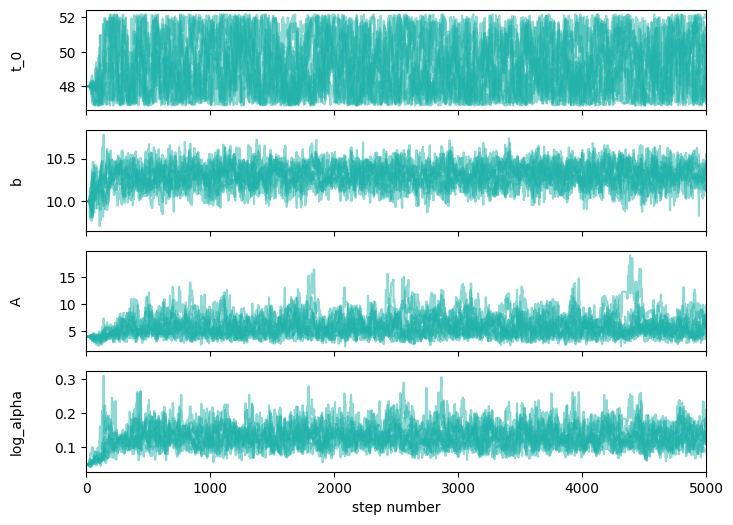

In [21]:
print(sampler.chain.shape) #original chain structure : (nwalkers, nsteps, ndim)

fig, axes = plt.subplots(4, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["t_0", "b","A","log_alpha"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.5, color = "lightseagreen")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [71]:
burn = 200  

emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print("burned and flattened chain ",emcee_trace.shape) 
emcee_trace.flatten()
len(emcee_trace.flatten())

burned and flattened chain  (48000, 4)


192000

thinning ---> take autocorrelation length into account, burn-in is now a few times the autocorrelation length

In [72]:
print(sampler.chain.shape) 
print(sampler.acceptance_fraction)
tau = sampler.get_autocorr_time()
print('autocorrelation time ( how many steps to forget where it started):', tau, "Burn-in will be a few times ", tau[0])
thin = int(np.mean(tau)/2) # thin by  half the autocorrelation time
burn = thin*10

# flatten the thinned chain, to get a flat list of samples
emcee_trace = sampler.get_chain(discard=burn, thin=thin, flat=True).flatten()
print("trace shape:", emcee_trace.shape)


emcee_thinned = sampler.get_chain(discard=burn, thin=thin, flat=True)
print("thinned MC shape: ", emcee_thinned.shape)

(10, 5000, 4)
[0.53   0.5318 0.5376 0.5286 0.5246 0.5122 0.53   0.5424 0.4956 0.5316]
autocorrelation time ( how many steps to forget where it started): [78.08307656 55.22047357 75.50073909 61.45980874] Burn-in will be a few times  78.0830765647757
trace shape: (5640,)
thinned MC shape:  (1410, 4)


In [ ]:
sampler.get_chain(discard=burn, thin=thin, flat=True).shape


plt.plot(emcee_thinned[:,0], color = "lightseagreen")

mean_t0 = np.mean(emcee_thinned[:,0])
print(mean_t0)
median_t0 = np.median(emcee_thinned[:,0])

plt.axhline(mean_t0, color='r', linestyle='dashed', linewidth=1, label = "mean")
plt.axhline(median_t0, color='b', linestyle='dashed', linewidth=1, label = "median")
plt.legend()

corner plot

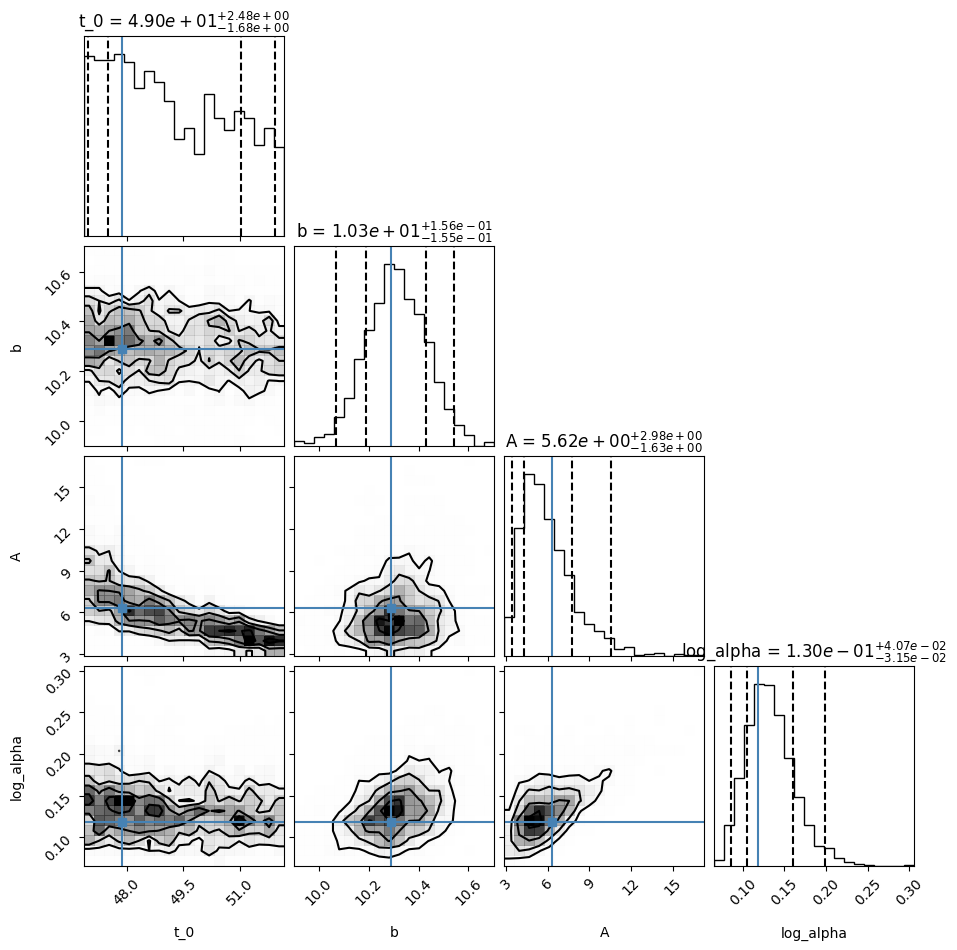

In [74]:
#I don't have the true values, I can plot the values i got from max likelihood estimation
fig = corner.corner(emcee_thinned, labels=labels, truths=par, 
                    quantiles= (0.025, 0.16, 0.84,0.9725), 
                    color = "black", title_quantiles=(0.10, 0.5, 0.90), 
                    show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 12},
                    plot_contours=True, plot_density=True, plot_datapoints=False, smooth=0.5);

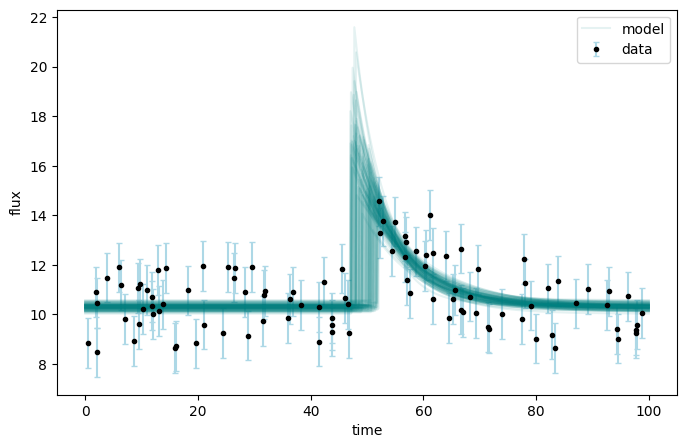

In [75]:
# now I need to choose 100 random samples from the burned, thinned chain
random_samples = np.random.choice(emcee_thinned.shape[0], size=100, replace=False)
selected_samples = emcee_thinned[random_samples]

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1, label='data')

yfit = model_(xgrid, selected_samples[0])
ax.plot(xgrid, yfit, color='teal', alpha=0.1, label='model')

for sample in selected_samples:
    yfit = model_(xgrid, sample)
    ax.plot(xgrid, yfit, color='teal', alpha=0.1)

ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.legend(loc='best', fontsize=10)
plt.show()

In [76]:
median_t0 = np.median(emcee_thinned[:, 0])
lower_t0 = np.percentile(emcee_thinned[:, 0], 5)
upper_t0 = np.percentile(emcee_thinned[:, 0], 95)
print(f"t_0 = {median_t0:.2f} +{upper_t0 - median_t0:.2f} -{median_t0 - lower_t0:.2f}")

median_b = np.median(emcee_thinned[:, 1])
lower_b = np.percentile(emcee_thinned[:, 1], 5)
upper_b = np.percentile(emcee_thinned[:, 1], 95)
print(f"b = {median_b:.2f} +{upper_b - median_b:.2f} -{median_b - lower_b:.2f}")

median_A = np.median(emcee_thinned[:, 2])
lower_A = np.percentile(emcee_thinned[:, 2], 5)
upper_A = np.percentile(emcee_thinned[:, 2], 95)
print(f"A = {median_A:.2f} +{upper_A - median_A:.2f} -{median_A - lower_A:.2f}")

median_log_alpha = np.median(emcee_thinned[:, 3])
lower_log_alpha = np.percentile(emcee_thinned[:, 3], 5)
upper_log_alpha = np.percentile(emcee_thinned[:, 3], 95)
print(f"log_alpha = {median_log_alpha:.2f} +{upper_log_alpha - median_log_alpha:.2f} -{median_log_alpha - lower_log_alpha:.2f}")


t_0 = 48.95 +2.85 -1.89
b = 10.31 +0.20 -0.20
A = 5.62 +4.26 -1.94
log_alpha = 0.13 +0.06 -0.04


## calculates the integrated autocorrelation time, burn-in, thinning

In [26]:
print(sampler.chain.shape) 
print(sampler.acceptance_fraction)


# Calculate the integrated autocorrelation time: how many steps to forget where it started
tau = sampler.get_autocorr_time()
print("Integrated autocorrelation time:", tau)

# Determine the thinning factor 
thin = int(np.mean(tau)/2) # thin by  half the autocorrelation time
print("Thinning factor:", thin)

# Determine the burn-in period
burnin = thin*20
print("Burn-in period:", burnin)

# Apply burn-in and thinning
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("Shape of the thinned and flattened samples:", flat_samples.shape)

if flat_samples.shape[0] < 1000: # Check if enough samples remain
    print("Warning: The number of samples after thinning is small. Consider running the MCMC for longer.")


(10, 5000, 4)
[0.5356 0.5292 0.5242 0.5458 0.5456 0.516  0.5262 0.546  0.51   0.5228]
Integrated autocorrelation time: [86.00043894 75.56170866 93.38975079 80.32605091]
Thinning factor: 41
Burn-in period: 820
Shape of the thinned and flattened samples: (1010, 4)


49.19602169181547


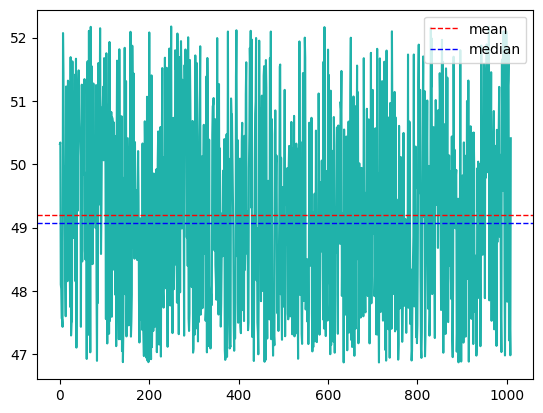

In [29]:
sampler.get_chain(discard=burnin, thin=thin, flat=True).shape


plt.plot(flat_samples[:,0], color = "lightseagreen")

mean_t0 = np.mean(flat_samples[:,0])
print(mean_t0)
median_t0 = np.median(flat_samples[:,0])

plt.axhline(mean_t0, color='r', linestyle='dashed', linewidth=1, label = "mean")
plt.axhline(median_t0, color='b', linestyle='dashed', linewidth=1, label = "median")
plt.legend()

## Corner plots

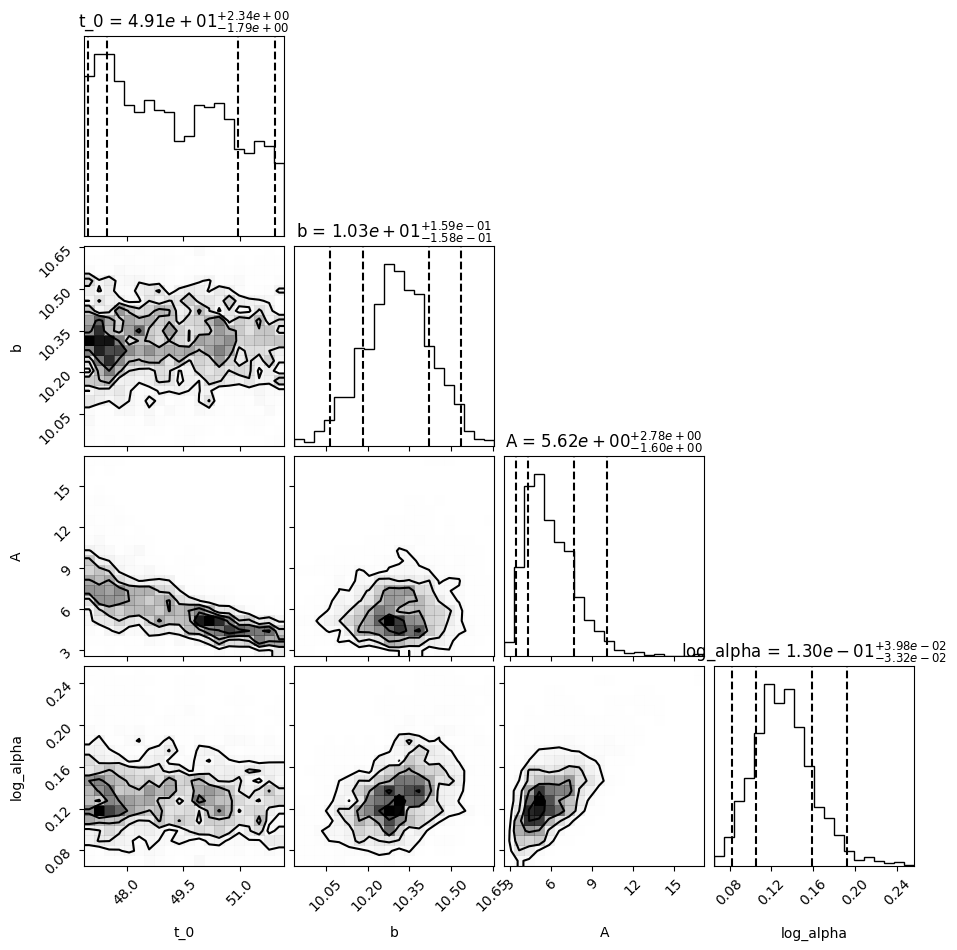

In [32]:
fig = corner.corner(flat_samples, labels=labels, 
                    quantiles= (0.025, 0.16, 0.84,0.9725), 
                    color = "black", title_quantiles=(0.10, 0.5, 0.90), 
                    show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 12},
                    plot_contours=True, plot_density=True, plot_datapoints=False, smooth=0.5);

## 📊 Come leggere un corner plot

Un **corner plot** è un modo compatto per visualizzare le distribuzioni posteriori dei parametri stimati con metodi Bayesiani (es. MCMC o Nested Sampling).  
Mostra contemporaneamente le **distribuzioni marginali** di ciascun parametro e le **correlazioni** tra coppie di parametri.

---

### 🔹 Struttura del grafico
- **Diagonale principale**: ogni riquadro contiene l’istogramma (o la densità stimata) della distribuzione marginale di un parametro.  
  - Le linee verticali indicano **quantili** scelti (nel nostro caso 2.5%, 16%, 84%, 97.5%).  
  - Questo corrisponde a intervalli credibili al 68% e 95%.  
  - Nei titoli sopra gli istogrammi vengono riportati valori come mediana e quantili (ad esempio 10%, 50%, 90%).  

- **Pannelli fuori diagonale**: mostrano le distribuzioni **bivariate** di coppie di parametri.  
  - Le **curve di contorno** racchiudono tipicamente il 68% e il 95% della probabilità (analoghe alle ellissi $1\sigma$ e $2\sigma$).  
  - Se le ellissi sono **tonde**, i parametri sono poco correlati.  
  - Se sono **allungate**, i parametri sono correlati: un cambiamento in uno implica un cambiamento nell’altro.  

---

### 🔹 Intervalli credibili
Se consideriamo un parametro $ \theta $, il corner plot mostra:
- la **mediana**: valore centrale della distribuzione posteriore,
- l’**intervallo credibile al 68\%**: tra i quantili 16\% e 84\%,
- l’**intervallo credibile al 95\%**: tra i quantili 2.5\% e 97.5\%.

Questi intervalli sono l’analogo Bayesiano delle “barre di errore” e ci dicono l’incertezza sulle stime.

---

### 🔹 Interpretazione pratica
- Dalla **diagonale** leggi quanto ciascun parametro è vincolato dai dati e quali valori sono più probabili.  
- Dai **pannelli off-diagonal** leggi come due parametri si relazionano tra loro (indipendenza o correlazione).  

In sintesi, il corner plot ti permette di vedere **quanto sono ben determinati i parametri** e **se esistono degenerazioni** tra di essi.

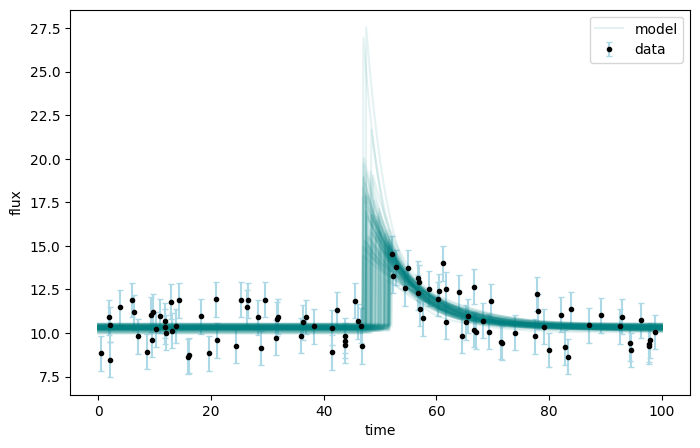

In [37]:
# now I need to choose 100 random samples from the burned, thinned chain
random_samples = np.random.choice(flat_samples.shape[0], size=100, replace=False)
selected_samples = flat_samples[random_samples]
xgrid = np.linspace(0, 100, 1000)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(t, y, yerr, fmt='ok', ecolor='lightblue', markersize=3, capsize=2, capthick=1, label='data')

yfit = model_(xgrid, selected_samples[0])
ax.plot(xgrid, yfit, color='teal', alpha=0.1, label='model')

for sample in selected_samples:
    yfit = model_(xgrid, sample)
    ax.plot(xgrid, yfit, color='teal', alpha=0.1)

ax.set_xlabel('time')
ax.set_ylabel('flux')
ax.legend(loc='best', fontsize=10)
plt.show()

In [38]:
# Cell X — summary statistics after plotting 100 posterior samples

# b
median_b = np.median(flat_samples[:, 0])
lower_b = np.percentile(flat_samples[:, 0], 5)
upper_b = np.percentile(flat_samples[:, 0], 95)
print(f"b = {median_b:.2f} +{upper_b - median_b:.2f} -{median_b - lower_b:.2f}")

# A
median_A = np.median(flat_samples[:, 1])
lower_A = np.percentile(flat_samples[:, 1], 5)
upper_A = np.percentile(flat_samples[:, 1], 95)
print(f"A = {median_A:.2f} +{upper_A - median_A:.2f} -{median_A - lower_A:.2f}")

# t0
median_t0 = np.median(flat_samples[:, 2])
lower_t0 = np.percentile(flat_samples[:, 2], 5)
upper_t0 = np.percentile(flat_samples[:, 2], 95)
print(f"t0 = {median_t0:.2f} +{upper_t0 - median_t0:.2f} -{median_t0 - lower_t0:.2f}")

# ln_alpha
median_log_alpha = np.median(flat_samples[:, 3])
lower_log_alpha = np.percentile(flat_samples[:, 3], 5)
upper_log_alpha = np.percentile(flat_samples[:, 3], 95)
print(f"ln_alpha = {median_log_alpha:.2f} "
      f"+{upper_log_alpha - median_log_alpha:.2f} "
      f"-{median_log_alpha - lower_log_alpha:.2f}")

# (optional) convert also to alpha = exp(ln_alpha)
median_alpha = np.exp(median_log_alpha)
lower_alpha = np.exp(lower_log_alpha)
upper_alpha = np.exp(upper_log_alpha)
print(f"alpha = {median_alpha:.4f} "
      f"+{upper_alpha - median_alpha:.4f} "
      f"-{median_alpha - lower_alpha:.4f}")


b = 49.07 +2.66 -2.00
A = 10.31 +0.20 -0.21
t0 = 5.62 +3.71 -1.95
ln_alpha = 0.13 +0.05 -0.04
alpha = 1.1389 +0.0609 -0.0459


## Nested sampling

## 🔎 Intuizione sul Nested Sampling

**Nested Sampling** è un algoritmo di inferenza bayesiana ideato da John Skilling (2004).  
Il suo scopo principale è stimare **l’evidenza bayesiana**:

$\[
Z = \int L(\theta) \, \pi(\theta)\, d\theta
\]$

dove:
- $\(L(\theta)\) = likelihood$,
- $\(\pi(\theta)\) = prior.$

### 🎯 Perché serve?
- Gli algoritmi MCMC sono ottimi per esplorare il **posterior** $\(p(\theta|dati)\)$,  
  ma non stimano bene l’evidenza \(Z\), che è essenziale per **confrontare modelli**.
- Nested Sampling è progettato per calcolare \(Z\), e come bonus fornisce anche campioni posteriori.

---

### ⚙️ Come funziona intuitivamente
1. **Inizializza** un insieme di punti ("live points") presi dal prior.
2. **Trova il punto con likelihood più bassa** e scartalo.
3. **Rimpiazzalo** con un nuovo punto estratto dal prior, ma **vincolato a una likelihood maggiore**.
4. Ripeti i passi 2–3: in questo modo i punti “si annidano” (`nested`) in regioni di likelihood sempre più alta.
5. A ogni iterazione, stimiamo:
   - il volume di prior rimasto,
   - il contributo all’integrale dell’evidenza.
6. Alla fine:
   - otteniamo una stima di \(Z\),
   - otteniamo campioni del **posterior** pesati correttamente.

---

### 🧩 Un’analogia
Immagina di cercare un tesoro in una valle:
- All’inizio esplori tutta la valle (prior).
- Poi scarti le zone meno promettenti (likelihood bassa).
- Ti concentri sempre più sulle zone ricche di indizi.
- Alla fine trovi il tesoro (massimo del posterior),  
  ma sai anche **quanto era improbabile trovarlo lì per caso** (evidenza).

---

### 📊 Risultati
- Nested Sampling fornisce:
  - **Evidenza bayesiana \(Z\)** → confronto tra modelli.
  - **Campioni posteriori** → stime e incertezze sui parametri.

---

### 🆚 Confronto con MCMC
- **MCMC**: ottimo per campionare posterior complicati, ma stima male \(Z\).
- **Nested Sampling**: progettato per stimare \(Z\), ma può essere più costoso in alta dimensione.

In [39]:
import dynesty

## 🔎 Nested Sampling per il modello del burst

In questa parte rifacciamo il fit del modello del burst, questa volta usando **Nested Sampling** invece dell’MCMC.

## 🔑 Nested Sampling e lo spazio unitario

L’idea chiave di **Nested Sampling** è che l’algoritmo lavora in uno **spazio unitario** $[0,1]^d$, chiamato *unit hypercube*, dove $d$ è il numero di parametri del modello.  

Per usare questo approccio, dobbiamo definire due funzioni principali:

---

### 1. Funzione di log-likelihood: `loglike(theta)`  
- Prende in input un vettore di **parametri fisici**:  
  $\theta = (t_0, b, A, \alpha)$  
- Calcola il modello del burst $y_\mathrm{model}(t|\theta)$ e restituisce il **logaritmo della likelihood gaussiana** dei dati:  
  $$
  \log \mathcal{L}(\theta) = -\frac{1}{2} \sum_i \frac{(y_i - y_\mathrm{model}(t_i|\theta))^2}{\sigma_i^2} - \frac{1}{2} \sum_i \log (2 \pi \sigma_i^2)
  $$

---

### 2. Trasformazione del prior: `prior_transform(u)`  
- Prende un **punto $u \in [0,1]^d$** uniforme nello *unit hypercube*.  
- Lo trasforma in un punto nello **spazio dei parametri fisici**, rispettando i priors scelti:  
  $$
  \begin{aligned}
  t_0 &\sim \mathrm{Uniform}(0,100) \\
  b   &\sim \mathrm{Uniform}(0,50) \\
  A   &\sim \mathrm{Uniform}(0,50) \\
  \ln \alpha &\sim \mathrm{Uniform}(-5,5), \quad \alpha = e^{\ln \alpha}
  \end{aligned}
  $$  
- Questa trasformazione garantisce che ogni campione uniforme $u$ sia correttamente mappato nello spazio fisico dei parametri.  
- Per implementarla si usa la funzione **`ppf` (percent point function)** di `scipy.stats.uniform`, che mappa un numero uniforme $u \in [0,1]$ in un valore distribuito secondo la distribuzione desiderata.

---

In pratica: il *unit hypercube* standardizza il problema, mentre `prior_transform` riporta i campioni ai parametri fisici. Questo è essenziale per calcolare correttamente la likelihood e l’evidenza bayesiana.

3. **Eseguire il sampler** con `dynesty.NestedSampler`, specificando:  
   - `loglike` (la funzione di log-likelihood)  
   - `prior_transform` (la mappatura del prior)  
   - `ndim = 4` (numero di parametri)  
   - `nlive` = numero di “live points” usati durante la ricerca (più grande = risultati più stabili, ma più costosi).

---

### ✅ Check di correttezza
Un controllo importante è verificare che il **corner plot dei campioni posteriori ottenuti con Nested Sampling** sia compatibile con quello ottenuto con l’MCMC nella sezione precedente.  
Se la trasformazione del prior e la likelihood sono implementati correttamente, le distribuzioni marginali dei parametri devono coincidere entro l’incertezza numerica.

In [80]:
# ---- Modello (stesso di prima) ----
def model_(t, par):
    modello = []
    for time in t:
        if (time < par[0]):  # t0
            modello.append(par[1])  # b
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time - par[0])))  # b + A*exp(-alpha*(t-t0))
    return np.array(modello)

# ---- Likelihood (log-likelihood per dynesty) ----
def loglike(theta):
    t0, b, A, alpha = theta
    x = data[:, 0]
    y = data[:, 1]
    sigma_y = data[:, 2]
    y_model = model_(x, theta)
    var = sigma_y**2
    chi2 = np.sum((y - y_model)**2 / var)
    return -0.5 * (chi2 + np.sum(np.log(2 * np.pi * var)))

# ---- Prior transform: unit cube → parametri fisici ----
def prior_transform(u):
    # u è in [0,1]^4
    t0 = stats.uniform(0, 100).ppf(u[0])     # Uniform(0,100)
    b = stats.uniform(0, 50).ppf(u[1])       # Uniform(0,50)
    A = stats.uniform(0, 50).ppf(u[2])       # Uniform(0,50)
    ln_alpha = stats.uniform(-5, 10).ppf(u[3])  # Uniform(-5,5)
    alpha = np.exp(ln_alpha)
    return np.array([t0, b, A, alpha])

In [81]:
# ---- Nested Sampling ----
ndim = 4
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim, nlive=500)
sampler.run_nested()
res = sampler.results
print("done")

/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.wa

done


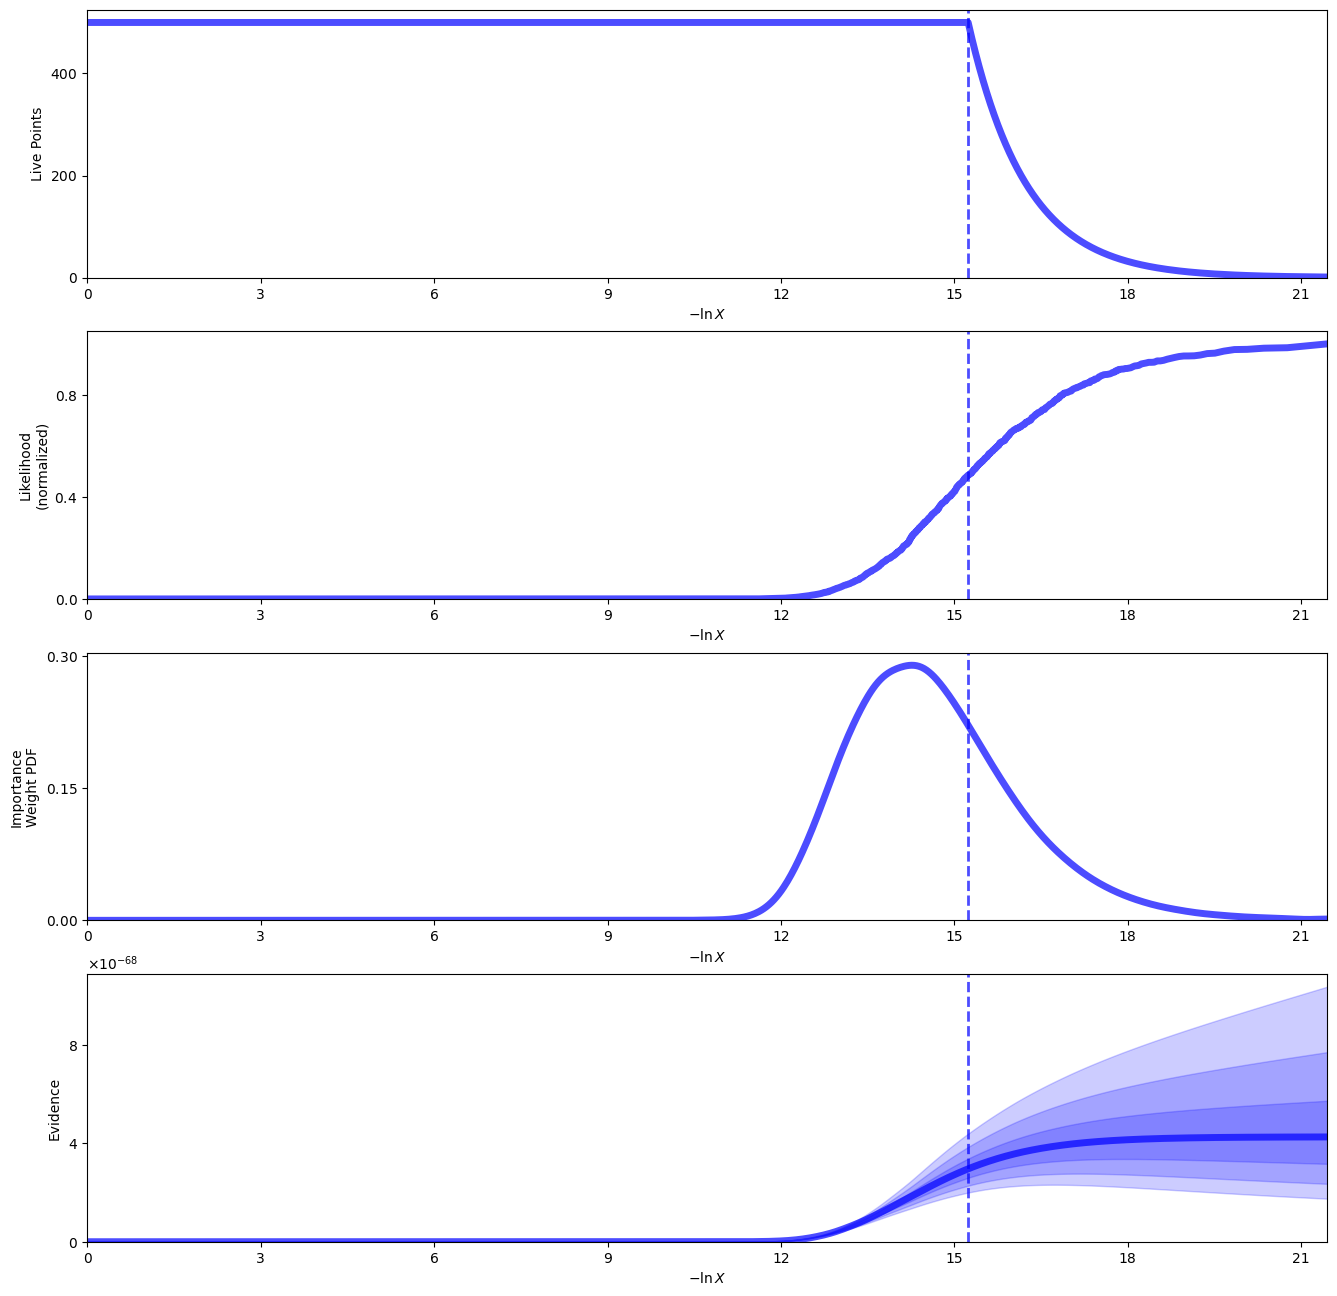

In [82]:
from dynesty import plotting as dyplot
plt.rcParams['figure.figsize'] = (8,8)
rfig, raxes = dyplot.runplot(res)

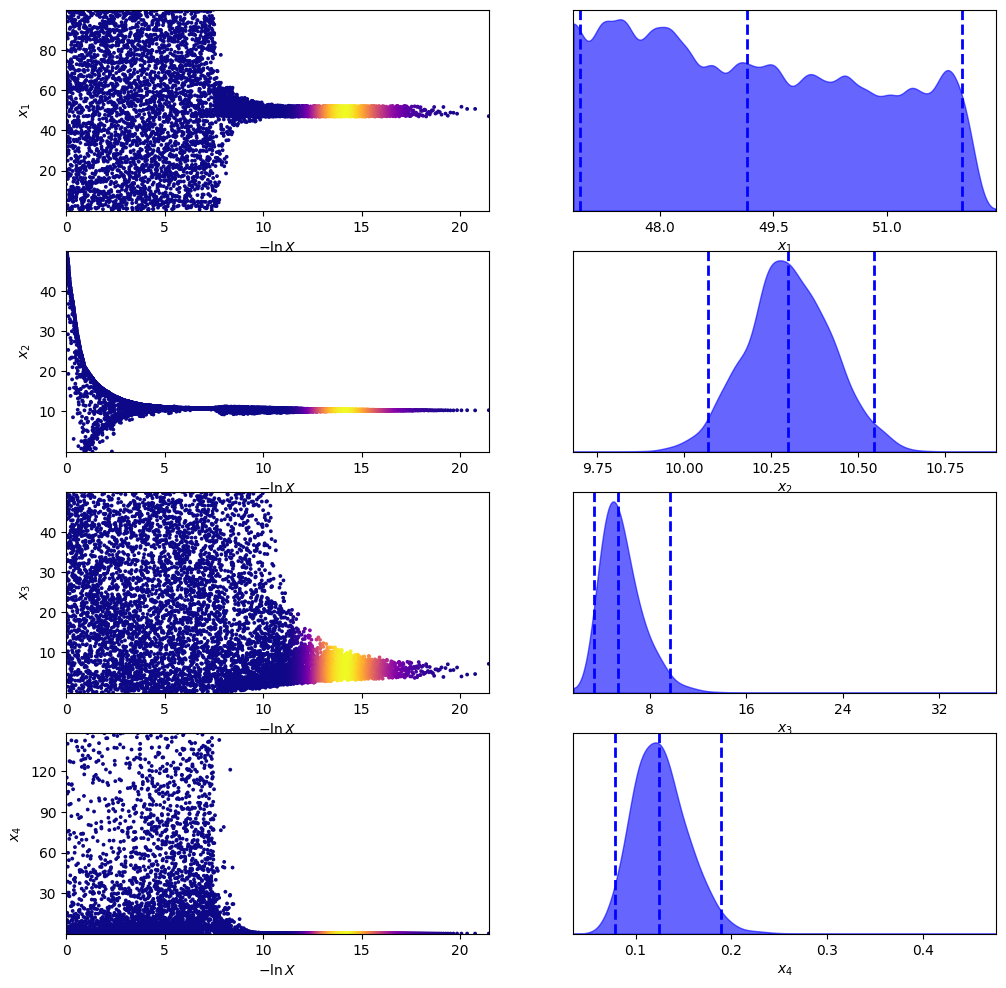

In [83]:
tfig, taxes = dyplot.traceplot(res)

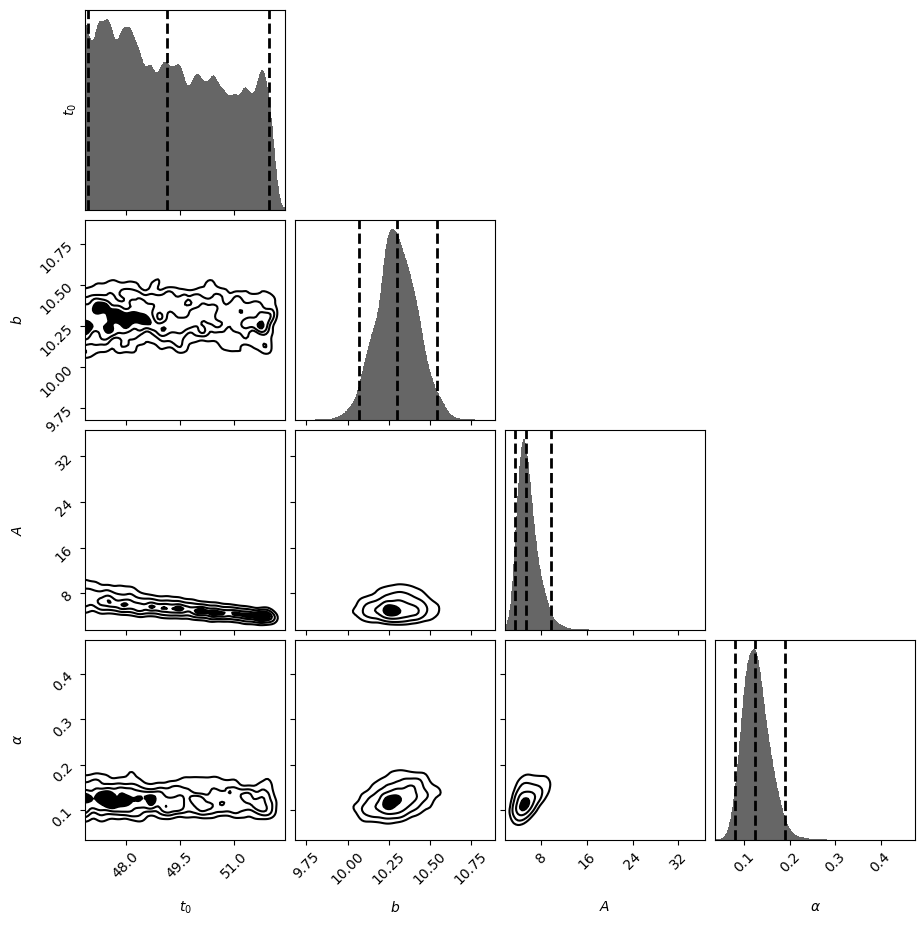

In [84]:
cfig, caxes = dyplot.cornerplot(res)
param_names = ["$t_0$", "$b$", "$A$", "$\\alpha$"]

for i, ax in enumerate(caxes[:, 0]):
    ax.set_ylabel(param_names[i])
for i, ax in enumerate(caxes[-1, :]):
    ax.set_xlabel(param_names[i])




In [85]:
## Weighted credible regions from dynesty results

def calculate_weighted_credible_interval(samples, weights, credible_level=0.95):
    """
    Compute median and credible interval for weighted posterior samples.
    """
    # Normalize weights
    weights = weights / np.sum(weights)

    # Sort samples according to value
    sorted_idx = np.argsort(samples)
    sorted_samples = samples[sorted_idx]
    sorted_weights = weights[sorted_idx]

    # Cumulative distribution
    cumsum_weights = np.cumsum(sorted_weights)

    # Median
    median_idx = np.searchsorted(cumsum_weights, 0.5)
    median = sorted_samples[median_idx]

    # Lower and upper bounds
    alpha = (1 - credible_level) / 2
    lower_idx = np.searchsorted(cumsum_weights, alpha)
    upper_idx = np.searchsorted(cumsum_weights, 1 - alpha)

    lower = sorted_samples[lower_idx]
    upper = sorted_samples[upper_idx]

    return median, lower, upper


def get_parameter_estimates(results, param_idx, credible_level=0.95):
    """
    Extract credible intervals for a parameter from dynesty results.
    param_idx: index of parameter (0=t0, 1=b, 2=A, 3=alpha)
    """
    samples = results.samples[:, param_idx]
    # dynesty: logwt = log-weights, logz[-1] = log-evidence normalization
    weights = np.exp(results.logwt - results.logz[-1])
    return calculate_weighted_credible_interval(samples, weights, credible_level)

In [86]:
# Get estimates for each parameter
median_t0, lower_t0, upper_t0 = get_parameter_estimates(res, 0)
median_b, lower_b, upper_b   = get_parameter_estimates(res, 1)
median_A, lower_A, upper_A   = get_parameter_estimates(res, 2)
median_alpha, lower_alpha, upper_alpha = get_parameter_estimates(res, 3)

print(f"t0 = {median_t0:.2f} (+{upper_t0-median_t0:.2f}, -{median_t0-lower_t0:.2f})")
print(f"b  = {median_b:.2f} (+{upper_b-median_b:.2f}, -{median_b-lower_b:.2f})")
print(f"A  = {median_A:.2f} (+{upper_A-median_A:.2f}, -{median_A-lower_A:.2f})")
print(f"alpha = {median_alpha:.4f} (+{upper_alpha-median_alpha:.4f}, -{median_alpha-lower_alpha:.4f})")

t0 = 49.16 (+2.82, -2.20)
b  = 10.30 (+0.25, -0.23)
A  = 5.37 (+4.34, -2.01)
alpha = 0.1239 (+0.0650, -0.0451)


## Gaussian profile

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [87]:
def model_gauss(tarr, par):
    # par = [t0, b, A, sigma_w]
    t0, b, A, sigma_w = par
    return b + A * np.exp(-0.5 * ((tarr - t0) / sigma_w)**2)

def loglike_gauss(theta):
    """theta in physical space: [t0, b, A, sigma_w]"""
    y_model = model_gauss(t, theta)
    var = yerr**2
    chi2 = np.sum((y - y_model)**2 / var)
    return -0.5 * (chi2 + np.sum(np.log(2*np.pi*var)))

def prior_transform_gauss(u):
    """u in [0,1]^4 -> physical params with chosen priors"""
    # t0 ~ Uniform(0,100)
    t0 = stats.uniform(0,100).ppf(u[0])
    # b  ~ Uniform(0,50)
    b  = stats.uniform(0,50).ppf(u[1])
    # A  ~ Uniform(0,50)
    A  = stats.uniform(0,50).ppf(u[2])
    # sigma_w: use log-uniform prior between 0.01 and 50
    ln_min = np.log(0.01)
    ln_max = np.log(50.0)
    ln_sigma = stats.uniform(ln_min, ln_max - ln_min).ppf(u[3])
    sigma_w = np.exp(ln_sigma)
    return np.array([t0, b, A, sigma_w])


In [88]:
print("Eseguo dynesty per il modello gaussiano")
ndim = 4
nlive = 500   
sampler_gauss = dynesty.NestedSampler(loglike_gauss, prior_transform_gauss, ndim=ndim, nlive=nlive)
sampler_gauss.run_nested()
res_gauss = sampler_gauss.results

Eseguo dynesty per il modello gaussiano (nlive = 400; aumenta nlive per più precisione)...


/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/Users/riccardobosonidemartini/Documents/.venv311/lib/python3.11/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.wa

In [89]:
# Estrazione evidenze e posterior samples pesati
# -------------------------
logZ_gauss = res_gauss.logz[-1]
logZerr_gauss = res_gauss.logzerr[-1]
samples_gauss = res_gauss.samples.copy()
weights_gauss = np.exp(res_gauss.logwt - res_gauss.logz[-1])
weights_gauss /= np.sum(weights_gauss)

In [90]:
# dal burst (res) estraiamo logZ e errore
logZ_burst = res.logz[-1]
logZerr_burst = res.logzerr[-1]


## Bayes factor

In [91]:
# -------------------------
# Confronto evidenze -> Bayes factor e scala di Jeffreys
# -------------------------
dlogZ = logZ_gauss - logZ_burst                 # naturale
BF = np.exp(dlogZ)                               # Bayes factor (gauss / burst)
log10_BF = dlogZ / np.log(10)

print("=== Evidence summary ===")
print(f"Burst    : logZ = {logZ_burst:.4f} ± {logZerr_burst:.4f}")
print(f"Gaussian : logZ = {logZ_gauss:.4f} ± {logZerr_gauss:.4f}")
print()
print(f"Delta logZ (gauss - burst) = {dlogZ:.4f}")
print(f"Bayes factor (gauss / burst) = {BF:.4f}")
print(f"log10(BF) = {log10_BF:.4f}")

# Jeffreys interpretation
def jeffreys_interpret(log10BF):
    x = abs(log10BF)
    if x < 0.5:
        return "Inconclusive (not worth more than a bare mention)"
    elif x < 1.0:
        return "Substantial evidence"
    elif x < 2.0:
        return "Strong evidence"
    else:
        return "Decisive evidence"

favored = "Gaussian" if dlogZ > 0 else "Burst"
print()
print(f"Preferred model by evidence: {favored}")
print("Jeffreys interpretation (based on log10(BF)):", jeffreys_interpret(log10_BF))

# Uncertainty combinata su Delta logZ (utile per giudicare robustezza)
dlogZ_err = np.sqrt(logZerr_gauss**2 + logZerr_burst**2)
print(f"\nApprox uncertainty on Delta logZ = {dlogZ_err:.4f}")
if abs(dlogZ) < 2*dlogZ_err:
    print("WARNING: Delta logZ is comparable to its uncertainty -> result may not be decisive.")


=== Evidence summary ===
Burst    : logZ = -155.1250 ± 0.2966
Gaussian : logZ = -160.5486 ± 0.3098

Delta logZ (gauss - burst) = -5.4236
Bayes factor (gauss / burst) = 0.0044
log10(BF) = -2.3554

Preferred model by evidence: Burst
Jeffreys interpretation (based on log10(BF)): Decisive evidence

Approx uncertainty on Delta logZ = 0.4288
